# **Practice 1 - Rate-Encoding for SNN**
## Sep. 2024

This file is a modification of snnTorch tutorial written by Jason K. Eshraghian.



# Introduction
In this tutorial, you will:
* Understand the role of `DataLoader`
* Learn how to rate-encode static image dataset to make it use for SNN.

In [1]:
#Install snnTorch
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 11.2 MB/s eta 0:00:00
DEPRECATION: pytorch-lightning 1.6.1 has a non-standard dependency specifier torch>=1.8.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


## 1. Setting up the MNIST Dataset

### 1.1. Import packages and setup environment

In [2]:
import snntorch as snn
import torch

In [3]:
# Training Parameters
batch_size=128
data_path='./mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
# dtype = torch.float

### 1.2 Download Dataset

In [4]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
                transforms.Resize((28,28)),             # resize the images to the given size
                transforms.ToTensor(),                  # convert image type to `Tensor`
                transforms.Normalize((0,), (1,))        # normalize
            ])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
print(type(mnist_train))
print(f"The size of mnist_train is {len(mnist_train)}")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:06<00:00, 1426717.27it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 147868.73it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 432537.88it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1368867.48it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

<class 'torchvision.datasets.mnist.MNIST'>
The size of mnist_train is 60000


If the above code block throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [ ]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)

### 1.3 Create DataLoader

* `mnist_train` contains image&label pair(sample)s of MNIST dataset for training.

* `DataLoader` divides the dataset into multiple mini-batches and we can iterate each mini-batch through the `DataLoader`.
* Mini-batch ?
    * The entire data is divided into small units and training is performed in those units.
    * This unit is the ***mini-batch***.
    * In other words, after adding all the losses obtained by passing the samples in one mini-batch through the network, backpropagation is performed to update the network parameters.

   

<center>
<img src='https://github.com/kimbss470/content/blob/master/img1.png?raw=true' width="500">
</center>


In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

Let's plot the 1st image of 1st mini-batch.

The size of `data_it` tensor is ``[128(=batch_size) x 1(=channel) x 28(=height) x 28(=widht)]``.

torch.Size([128, 1, 28, 28])


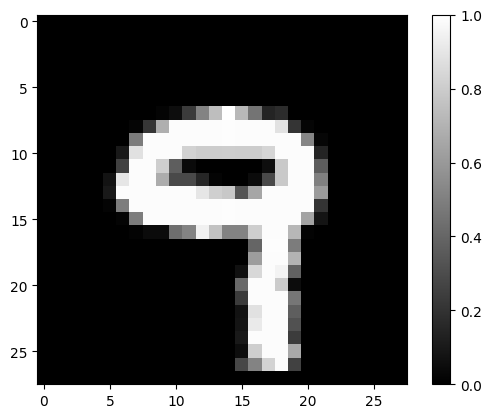

In [6]:
import matplotlib.pyplot as plt

data = iter(train_loader)
data_it, targets_it = next(data)
print(data_it.size())            # print the size of images of first mini-batch

plt.imshow(data_it[0, 0], cmap='gray') # visualize the first image
plt.colorbar()


## 2. Spike Encoding

Spiking Neural Networks (SNNs) are made to exploit time-varying data. And yet, MNIST is not a time-varying dataset.

For using MNIST with an SNN,

Convert the input into a spike train of sequence length `num_steps`, where each feature/pixel takes on a discrete value $X_{i,j} \in \{0, 1\}$.
In this case, MNIST is converted into a time-varying sequence of spikes that features a relation to the original image.


Followings are the most popular spiking encoding schemes

1.   ***Rate coding*** uses input features to determine spiking **frequency**
2.   ***Latency coding*** uses input features to determine spike **timing**
3.   ***Delta modulation*** uses the temporal **change** of input features to generate spikes


We will use ***Rate coding*** in the following labs.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true' width="1000">
</center>


### 2.1 Rate coding of MNIST

Each normalized input feature $a$ is used as the ***probability*** a spike occurs at any given time step  and the probability of success (spiking) is $p=a$. Explicitly, the probability a spike occurs is:

$${\rm P}(spiking) = a = 1 - {\rm P}(not\ spiking)$$

Create a vector filled with the value $a=0.7$ and encode it using the above technique:

In [7]:
# Define the number of time steps (i.e., number of Bernoulli trials)
num_steps = 10

# create vector filled with 0.7
raw_vector = torch.ones(num_steps)*0.7
print(raw_vector)

tensor([0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000])


In [8]:
# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([1., 0., 0., 1., 1., 1., 1., 1., 1., 0.])
The output is spiking 70.00% of the time.


Now try again, but increasing the length of `raw_vector`:

In [9]:
num_steps = 100

# create vector filled with 0.7
raw_vector = torch.ones(num_steps)*0.7
print(raw_vector)

tensor([0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
        0.7000])


In [10]:
# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 0.])
The output is spiking 70.00% of the time.


As `num_steps`$\rightarrow\infty$, the proportion of spikes approaches the original raw value.

In a similar way, `snnTorch` provides `spikegen.rate` method which can be used to generate a rate-coded sample of data. As each sample of MNIST is just an image, we can use `num_steps` to repeat it across time.

In [11]:
from snntorch import spikegen

num_steps = 100

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)
print(f"The size of data_it: {data_it.size()}")

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)
print(f"The size of spike_data: {spike_data.size()}")

The size of data_it: torch.Size([128, 1, 28, 28])
The size of spike_data: torch.Size([100, 128, 1, 28, 28])


The structure of the input data is ``[num_steps x batch_size x channel x height x width]``:

<center>
<img src='https://github.com/kimbss470/content/blob/master/img4.png?raw=true' width="600">
</center>



### 2.2 Visualization

#### 2.2.1 Animation
snnTorch contains a module [`snntorch.spikeplot`](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html) that simplifies the process of visualizing, plotting, and animating spiking neurons.


In [12]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

To plot one sample of data, index into a single sample from the batch (B) dimension of `spike_data`, ``[T x B x 1 x 28 x 28]``:

In [13]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


`spikeplot.animator` makes it super simple to animate 2-D data.<br>


MovieWriter stderr:
ffmpeg: error while loading shared libraries: libopenh264.so.5: cannot open shared object file: No such file or directory



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '25.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpzwdkhkzy/temp.m4v']' returned non-zero exit status 127.

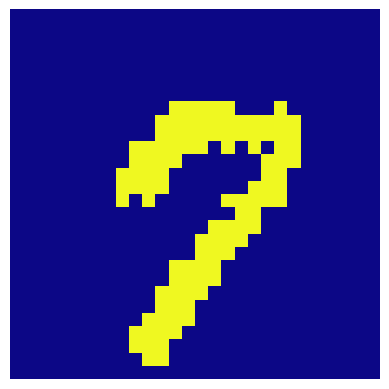

In [16]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

HTML(anim.to_html5_video())

#### 2.2.2 Raster Plots
Alternatively, we can generate a raster plot of an input sample. This requires reshaping the sample into a 2-D tensor, where 'time' is the first dimension. Pass this sample into the function `spikeplot.raster`.

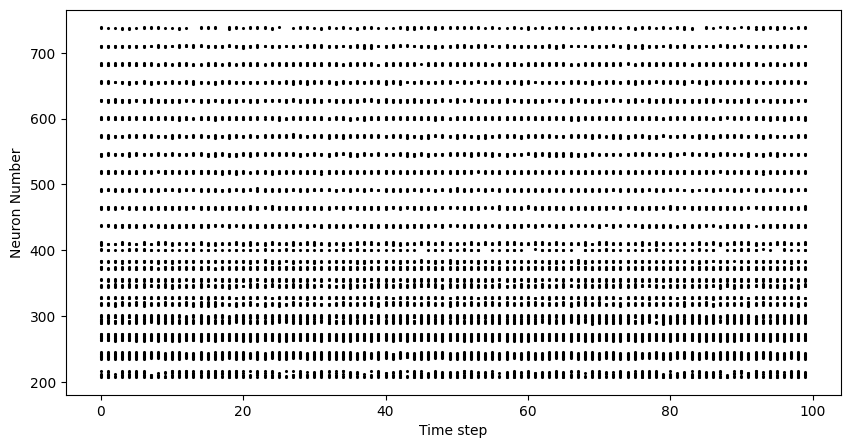

In [17]:
# Reshape
spike_data_sample = spike_data_sample.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample, ax, s=1.5, c="black")


plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()